# Import library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

In [2]:
cnn = pd.read_excel('cnn.xlsx')
kompas = pd.read_excel('kompas.xlsx')
tempo = pd.read_excel('tempo.xlsx')
turnbackhoax = pd.read_excel('turnbackhoax.xlsx')

In [3]:
cnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9630 entries, 0 to 9629
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  9630 non-null   int64 
 1   Title       9630 non-null   object
 2   Timestamp   9630 non-null   object
 3   FullText    9630 non-null   object
 4   Tags        9627 non-null   object
 5   Author      9630 non-null   object
 6   Url         9630 non-null   object
 7   text_new    9630 non-null   object
 8   hoax        9630 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 677.2+ KB


In [4]:
kompas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4750 non-null   int64 
 1   Title       4729 non-null   object
 2   Timestamp   4729 non-null   object
 3   FullText    4723 non-null   object
 4   Tags        4592 non-null   object
 5   Author      4413 non-null   object
 6   Url         4750 non-null   object
 7   text_new    4723 non-null   object
 8   hoax        4750 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 334.1+ KB


In [5]:
tempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6592 entries, 0 to 6591
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6592 non-null   int64 
 1   Title       6592 non-null   object
 2   Timestamp   6592 non-null   object
 3   FullText    6592 non-null   object
 4   Tags        6591 non-null   object
 5   Author      6592 non-null   object
 6   Url         6592 non-null   object
 7   text_new    6592 non-null   object
 8   hoax        6592 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 463.6+ KB


In [6]:
turnbackhoax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10381 entries, 0 to 10380
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    10381 non-null  int64 
 1   Title         10381 non-null  object
 2   Timestamp     10381 non-null  object
 3   FullText      10381 non-null  object
 4   Tags          10381 non-null  object
 5   Author        10381 non-null  object
 6   Url           10381 non-null  object
 7   politik       10381 non-null  int64 
 8   Narasi        10381 non-null  object
 9   Clean Narasi  6502 non-null   object
 10  hoax          10381 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 892.2+ KB


Menggabungkan data dari berbagai platform berita tersebut menjadi sebuah dataframe.

In [7]:
df = pd.concat([
    cnn[['text_new', 'hoax']].rename(columns={'text_new': 'news', 'hoax': 'label'}),
    kompas[['text_new', 'hoax']].rename(columns={'text_new': 'news', 'hoax': 'label'}),
    tempo[['text_new', 'hoax']].rename(columns={'text_new': 'news', 'hoax': 'label'}),
    turnbackhoax[['Clean Narasi', 'hoax']].rename(columns={'Clean Narasi': 'news', 'hoax': 'label'})
], ignore_index=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31353 entries, 0 to 31352
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    27447 non-null  object
 1   label   31353 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 490.0+ KB


In [9]:
df['label'].unique()

array([0, 1])

In [10]:
print(f"\nMissing Values:\n{df.isnull().sum()}")


Missing Values:
news     3906
label       0
dtype: int64


In [11]:
df = df.dropna()
print(f"\nMissing Values:\n{df.isnull().sum()}")


Missing Values:
news     0
label    0
dtype: int64


In [12]:
print(f"\nJumlah baris duplikat: {df.duplicated().sum()}")


Jumlah baris duplikat: 16


In [13]:
all_duplicates_boolean = df.duplicated(keep=False)
all_duplicates_data = df[all_duplicates_boolean].sort_values(by=df.columns.tolist())
print(all_duplicates_data)

                                                    news  label
23609  (Narasi diterjemahkan ke dalam bahasa Indonesi...      1
24120  (Narasi diterjemahkan ke dalam bahasa Indonesi...      1
26634  BERDALIH MELAKUKAN SWEEPING 4 DARI 6 ANGGOTA O...      1
30666  BERDALIH MELAKUKAN SWEEPING 4 DARI 6 ANGGOTA O...      1
30295  INFO DARI KAWAN-KAWAN : VAKSIN KANKER SERVIKS ...      1
31062  INFO DARI KAWAN-KAWAN : VAKSIN KANKER SERVIKS ...      1
29126  INNALILLAHI WAINNA LILLAHI ROZIUN . Hati-hati ...      1
30195  INNALILLAHI WAINNA LILLAHI ROZIUN . Hati-hati ...      1
31303  INSTING MAKELAR AKU Awalnya kaget, membaca ber...      1
31304  INSTING MAKELAR AKU Awalnya kaget, membaca ber...      1
25127  Ini baru berita top!!! :point_down: http://m.a...      1
25212  Ini baru berita top!!! :point_down: http://m.a...      1
26504  KADRUN itu dari PKI Barokallahu fiik Habib @hu...      1
26573  KADRUN itu dari PKI Barokallahu fiik Habib @hu...      1
21227  KISRUH NEGERI ANTARA PRIBUMI DAN 

In [14]:
df = df.drop_duplicates()
print(f"\nJumlah baris duplikat: {df.duplicated().sum()}")


Jumlah baris duplikat: 0


In [15]:
class_counts = df['label'].value_counts()
print(f"Distribusi kelas: {class_counts}")

Distribusi kelas: label
0    20945
1     6486
Name: count, dtype: int64


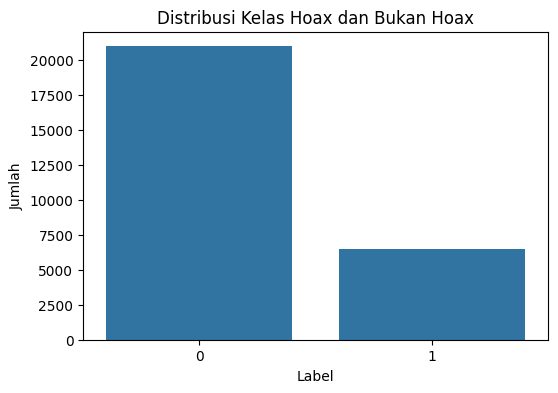

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label')
plt.title('Distribusi Kelas Hoax dan Bukan Hoax')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

In [17]:
df['text_length'] = df['news'].apply(lambda x: len(x.split()))
print(f"\nStatistik Deskriptif Panjang Teks:\n{df['text_length'].describe()}")


Statistik Deskriptif Panjang Teks:
count    27431.000000
mean       202.695308
std        169.052520
min          1.000000
25%         71.000000
50%        198.000000
75%        279.000000
max       4167.000000
Name: text_length, dtype: float64


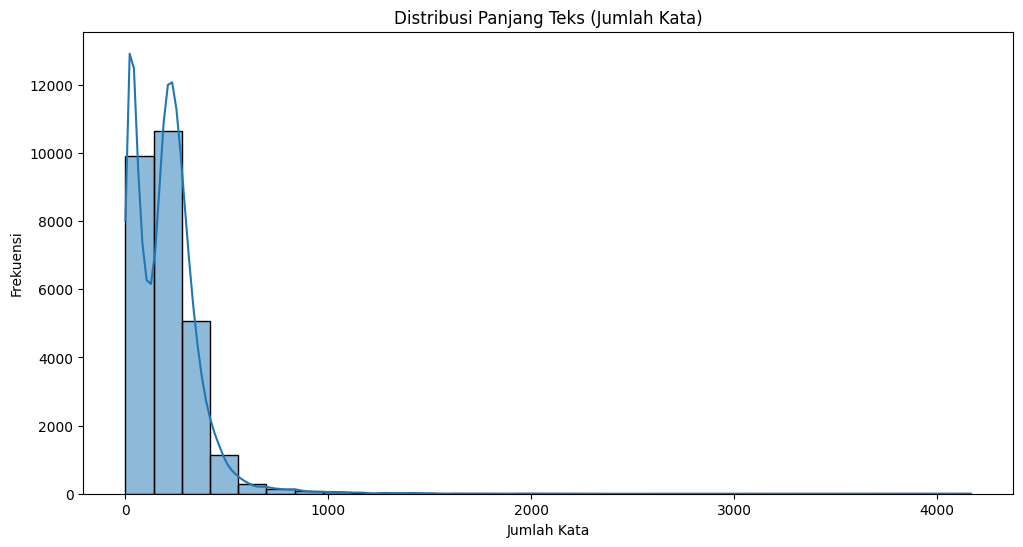

In [18]:
df['text_length'].tolist()
plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Distribusi Panjang Teks (Jumlah Kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

In [19]:
# stop words bahasa inggris
stop_words = set(stopwords.words('indonesian'))
def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

C:\Users\user\AppData\Local\Temp\ipykernel_15552\151263836.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='cividis')


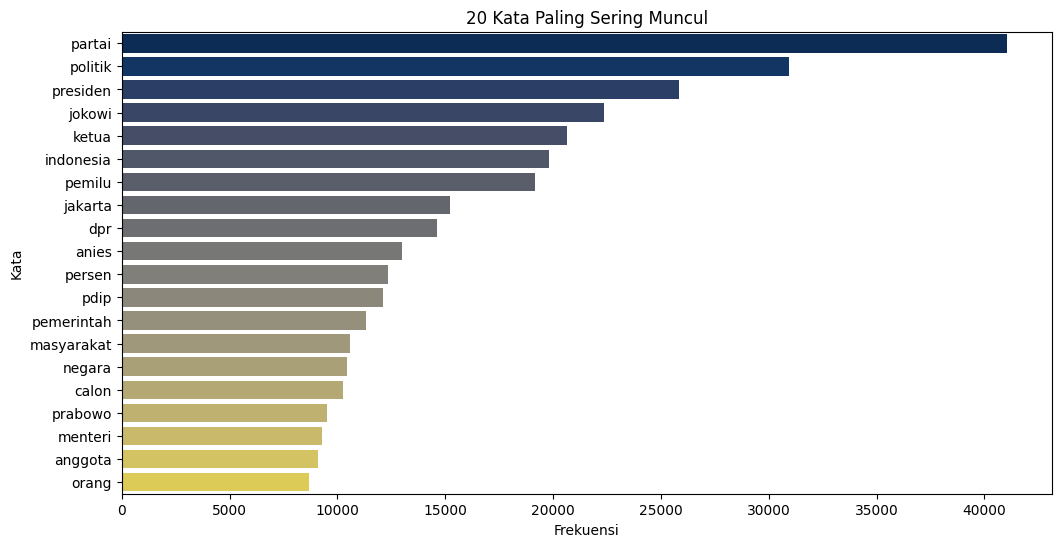

In [20]:
def clean_for_frequency(text):
    text = re.sub(r'[^a-z\s]', '', text.lower())
    text = remove_stopwords(text)
    return text

all_words = ' '.join(df['news'].apply(clean_for_frequency)).split()
word_counts = Counter(all_words)

# Kata-kata yang paling umum (Top 20)
most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette='cividis')
plt.title('20 Kata Paling Sering Muncul')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

In [21]:
def word_cloud_plot(data, title):
    word_cloud_text = ' '.join(data)
    wordcloud = WordCloud(
        width=800,
        height=400,
        max_words=200,
        background_color='white'
    ).generate(word_cloud_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [22]:
hoax_data = df[df['label'] == 1]['news'].apply(clean_for_frequency)
non_hoax_data = df[df['label'] == 0]['news'].apply(clean_for_frequency)

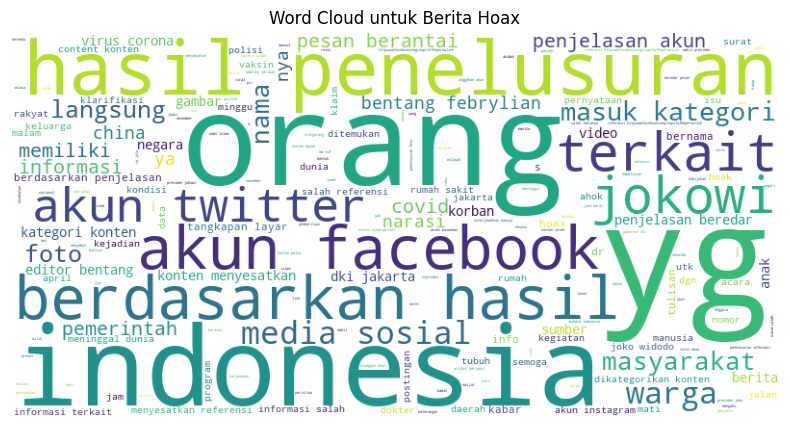

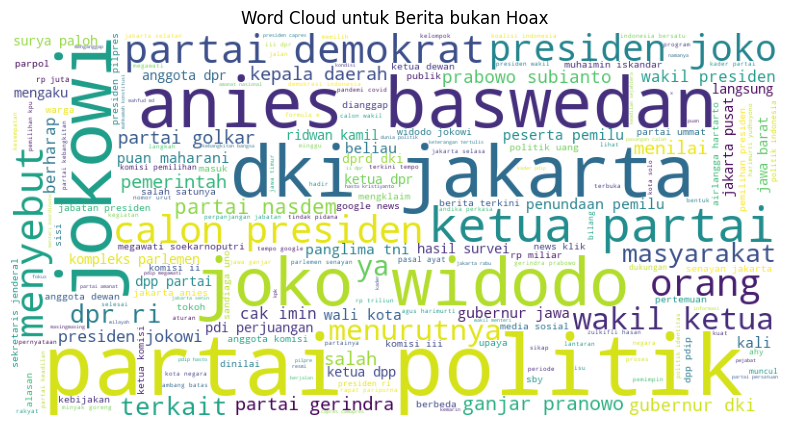

In [23]:
word_cloud_plot(hoax_data, 'Word Cloud untuk Berita Hoax')
word_cloud_plot(non_hoax_data, 'Word Cloud untuk Berita bukan Hoax')

In [24]:
def clean_text(s):
    
    patterns = [         
        r'\(Narasi diterjemahkan.*?\)',
        r"\bhoax\b",
        r"\bsalah\b",
        r"\bhoaks\b",
        r"\bkeliru\b",          
        r"\bmenyesatkan\b",     
        r"\bmanipulasi\b",
        r"\bfitnah\b",
        r"\bhasut\b",
        r"\bvalid\b",
        r"\bmisinformasi\b",
        r"\bdisinformasi\b",
        r"\bfakta\b",
        r"\bklarifikasi\b",
        r"tidak\s*benar",
        r"berita\s*bohong",
        r"ini\s*salah",
        r"hasil periksa fakta",
        r"pemeriksa fakta",
        r"turnbackhoax",
        r"cek fakta",
        r"liputan6",            
        r"kompas\.com",         
        r"cnn indonesia",
        r"\bakun\s*facebook\b",
        r"\bunggahan\b",
        r"\btangkapan\s*layar\b",
        r"\bscreenshot\b",
        
        r'Penjelasan\s*&?\s*Fakta\s*:', 
        r'Narasi\s*:',                   
        r'Klarifikasi\s*:',              
        r'Fakta\s*:',                    
        r'Beredar\s*kabar\s*:', 
        r"kategori\s*:",        
        r"sumber\s*:",          
        r"kesimpulan\s*:",      
        r"penjelasan\s*:",
    ]
    
    s = str(s)
    
    for pattern in patterns:
        s = re.sub(pattern, '', s, flags=re.IGNORECASE)

    s = re.sub(r'http\S+|www\S+|https\S+', '', s)
    s = re.sub(r"[^a-zA-Z0-9\s]", " ", s).lower()
    s = re.sub(r'<.*?>',' ', s)
    s = re.sub(r'\s+',' ', s).strip()
    return s

x= df['news'].apply(clean_text)


In [25]:
x = x.astype(str)
y = df['label'].astype(int)

In [26]:
x_train, x_temp, y_train, y_temp  = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
x_val, x_test, y_val, y_test  = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train size:", len(x_train))
print("Validation size:", len(x_val))
print("Test size:", len(x_test))

Train size: 21944
Validation size: 2743
Test size: 2744


In [27]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [29]:
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [30]:
train_dataset = TextDataset(
    texts=x_train.tolist(),
    labels=y_train.tolist(),
    tokenizer=tokenizer,
    max_len=128
)

val_dataset = TextDataset(
    texts=x_val.tolist(),
    labels=y_val.tolist(),
    tokenizer=tokenizer,
    max_len=128
)

test_dataset = TextDataset(
    texts=x_test.tolist(),
    labels=y_test.tolist(),
    tokenizer=tokenizer,
    max_len=128
)


In [31]:
counter = Counter(train_dataset.labels)
counter

Counter({0: 16755, 1: 5189})

## Balanced WRS

In [32]:
# Oversampling using WeightedRandomSampler
from torch.utils.data import WeightedRandomSampler

tr_labels = train_dataset.labels
class_sample_counts = Counter(tr_labels)
weights = [1 / class_sample_counts[label] for label in tr_labels]

sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)


In [33]:
# check value counts after oversampling
sampled_indices = list(sampler)
sampled_labels = [train_dataset.labels[i] for i in sampled_indices]
sampled_counter = Counter(sampled_labels)
sampled_counter

Counter({1: 11079, 0: 10865})

In [34]:
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle = False, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle = False, pin_memory = True)

In [35]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
    print(f"Training using: {device}")
else:
    device = torch.device("cpu")
    print(f"Training using: {device}")

True
NVIDIA GeForce RTX 4060 Laptop GPU
Training using: cuda


# Find best parameter

In [36]:
param_grid = {
    "learning_rate": [2e-5, 3e-5],
    "batch_size": [16, 32],
    "epochs": [3, 5]
}

best_f1 = 0
best_params = None
best_model_state = None

for lr in param_grid["learning_rate"]:
    for batch_size in param_grid["batch_size"]:
        for epochs in param_grid["epochs"]:

            print(f"\nTraining | LR={lr}, BS={batch_size}, Epochs={epochs}")

            train_loader = DataLoader(
                train_dataset,
                batch_size=batch_size,
                sampler=sampler,
                pin_memory=True
            )

            val_loader = DataLoader(
                val_dataset,
                batch_size=batch_size,
                shuffle=False,
                pin_memory=True
            )

            model = BertForSequenceClassification.from_pretrained(
                "indobenchmark/indobert-base-p1",
                num_labels=2
            ).to(device)
            

            optimizer = AdamW(model.parameters(), lr=lr)

            # ===== Fine-Tuning =====
            model.train()
            for epoch in range(epochs):
                total_loss = 0
                for batch in train_loader:
                    optimizer.zero_grad()

                    input_ids = batch["input_ids"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    labels = batch["labels"].to(device)

                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )

                    loss = outputs.loss
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()

                print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f}")

            # ===== Validation =====
            model.eval()
            val_preds, val_trues = [], []

            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch["input_ids"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    labels = batch["labels"].to(device)

                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask
                    )

                    preds = torch.argmax(outputs.logits, dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_trues.extend(labels.cpu().numpy())

            val_f1 = f1_score(val_trues, val_preds, average="weighted")
            print(f"Validation F1: {val_f1:.4f}")

            if val_f1 > best_f1:
                best_f1 = val_f1
                best_params = (lr, batch_size, epochs)
                best_model_state = model.state_dict()



Training | LR=2e-05, BS=16, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Loss: 0.0522
Epoch 2/3 | Loss: 0.0174
Epoch 3/3 | Loss: 0.0106
Validation F1: 0.9938

Training | LR=2e-05, BS=16, Epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 | Loss: 0.0475
Epoch 2/5 | Loss: 0.0127
Epoch 3/5 | Loss: 0.0114
Epoch 4/5 | Loss: 0.0082
Epoch 5/5 | Loss: 0.0052
Validation F1: 0.9931

Training | LR=2e-05, BS=32, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Loss: 0.0488
Epoch 2/3 | Loss: 0.0132
Epoch 3/3 | Loss: 0.0105
Validation F1: 0.9920

Training | LR=2e-05, BS=32, Epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 | Loss: 0.0490
Epoch 2/5 | Loss: 0.0118
Epoch 3/5 | Loss: 0.0085
Epoch 4/5 | Loss: 0.0055
Epoch 5/5 | Loss: 0.0057
Validation F1: 0.9864

Training | LR=3e-05, BS=16, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Loss: 0.0481
Epoch 2/3 | Loss: 0.0191
Epoch 3/3 | Loss: 0.0115
Validation F1: 0.9873

Training | LR=3e-05, BS=16, Epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 | Loss: 0.0520
Epoch 2/5 | Loss: 0.0190
Epoch 3/5 | Loss: 0.0139
Epoch 4/5 | Loss: 0.0083
Epoch 5/5 | Loss: 0.0725
Validation F1: 0.9612

Training | LR=3e-05, BS=32, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Loss: 0.0449
Epoch 2/3 | Loss: 0.0140
Epoch 3/3 | Loss: 0.0114
Validation F1: 0.9920

Training | LR=3e-05, BS=32, Epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 | Loss: 0.0470
Epoch 2/5 | Loss: 0.0183
Epoch 3/5 | Loss: 0.0091
Epoch 4/5 | Loss: 0.0082
Epoch 5/5 | Loss: 0.0071
Validation F1: 0.9898


In [37]:
print("\nBest Hyperparameters:")
print(f"LR={best_params[0]}, Batch Size={best_params[1]}, Epochs={best_params[2]}")

model.load_state_dict(best_model_state)
model.eval()

test_loader = DataLoader(
    test_dataset,
    batch_size=best_params[1],
    shuffle=False
)

test_preds, test_trues = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        preds = torch.argmax(outputs.logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_trues.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(test_trues, test_preds))
print("F1 Score:", f1_score(test_trues, test_preds, average="weighted"))
print(classification_report(test_trues, test_preds))



Best Hyperparameters:
LR=2e-05, Batch Size=16, Epochs=3
Accuracy: 0.9897959183673469
F1 Score: 0.9897403119467094
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2095
           1       0.99      0.96      0.98       649

    accuracy                           0.99      2744
   macro avg       0.99      0.98      0.99      2744
weighted avg       0.99      0.99      0.99      2744



In [38]:
model.save_pretrained("indobert_hoax_detector_best")

# Evaluasi model dengan dataset baru

In [39]:
eval_df = pd.read_csv("tribunnews_politik_full.csv")
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    199 non-null    object
 1   url      199 non-null    object
 2   content  199 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB


In [40]:
testing = eval_df['content']
testing.head()

0    TRIBUNNEWS.COM, JAKARTA - Istilah tebar pesona...
1    TRIBUNNEWS.COM, AMBON - Ketua Harian Partai So...
2    TRIBUNNEWS.COM, JAKARTA - Nahdlatul Ulama (NU)...
3    TRIBUNNEWS.COM, SURABAYA - Ketua DPD PDI Perju...
4    TRIBUNNEWS.COM, BANDUNG - Ketua DPW PSI Jawa B...
Name: content, dtype: object

In [41]:
testing = testing.apply(clean_text)

testing = testing.tolist()

In [42]:
class InferenceDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }


In [43]:
testing_dataset = InferenceDataset(testing, tokenizer)

loader = DataLoader(testing_dataset, batch_size=16, shuffle=False)

preds = []
probs = []

with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)

        predictions = torch.argmax(probabilities, dim=1)

        preds.extend(predictions.cpu().numpy())
        probs.extend(probabilities.max(dim=1).values.cpu().numpy())


In [44]:
print("Jumlah data :", len(testing))
print("Jumlah prediksi :", len(preds))


Jumlah data : 199
Jumlah prediksi : 199


In [45]:
eval_df['pred_label'] = preds
eval_df['confidence'] = probs

eval_df['pred_text'] = eval_df['pred_label'].map({
    0: 'VALID',
    1: 'HOAX'
})

eval_df.to_csv("hasil_prediksi_dataset_weight.csv", index=False)


In [46]:
eval_df.head(20)

,title,url,content,pred_label,confidence,pred_text
0,"Tebar Pesona di Tengah Banjir, Masih Efektifka...",https://www.tribunnews.com/nasional/7763757/te...,"TRIBUNNEWS.COM, JAKARTA - Istilah tebar pesona...",0,0.842602,VALID
1,PSI Puji Prabowo Akui Keberhasilan Jokowi: Pad...,https://www.tribunnews.com/nasional/7760973/ps...,"TRIBUNNEWS.COM, AMBON - Ketua Harian Partai So...",1,0.901555,HOAX
2,Nahdlatul Ulama Diharapkan Tetap Menjadi Rumah...,https://www.tribunnews.com/nasional/7759053/na...,"TRIBUNNEWS.COM, JAKARTA - Nahdlatul Ulama (NU)...",0,0.956307,VALID
3,Said Abdullah Sebut Regenerasi Pemilih Muda Ja...,https://www.tribunnews.com/nasional/7758786/sa...,"TRIBUNNEWS.COM, SURABAYA - Ketua DPD PDI Perju...",0,0.799130,VALID
4,Ketua PSI Jabar: Bakal Ada Badai Politik Usai ...,https://www.tribunnews.com/nasional/7755070/ke...,"TRIBUNNEWS.COM, BANDUNG - Ketua DPW PSI Jawa B...",1,0.926910,HOAX
5,Al Araf Ingatkan Penyimpangan Peran TNI: Janga...,https://www.tribunnews.com/nasional/7755009/al...,"TRIBUNNEWS.COM, JAKARTA - Ketua Badan Pengurus...",1,0.999223,HOAX
6,Pernyataan Prabowo Tak Takut Dikendalikan Joko...,https://www.tribunnews.com/nasional/7751889/pe...,TRIBUNNEWS.COM JAKARTA - Peneliti politik dari...,0,0.992230,VALID
7,Realisme Politik dan Penegakan Hukum Pemilu,https://www.tribunnews.com/tribunners/7750651/...,Aktif dalam pengawasan partisipatif dan penega...,0,0.999944,VALID
8,Partai Perindo Akan Menggelar Rakernas di Anco...,https://www.tribunnews.com/nasional/7749162/pa...,"TRIBUNNEWS.COM, JAKARTA - Partai Perindo diren...",0,0.935859,VALID
9,"Parpol Diminta Ciptakan Ekosistem Politik, Buk...",https://www.tribunnews.com/nasional/7747998/pa...,"TRIBUNNEWS.COM, JAKARTA - Partai politik (Parp...",0,0.999890,VALID


In [47]:
testing_label = eval_df['pred_text'].value_counts()
print(f"Distribusi kelas: {testing_label}")

Distribusi kelas: pred_text
VALID    105
HOAX      94
Name: count, dtype: int64
